**[Machine Learning Course Home Page](https://www.kaggle.com/learn/machine-learning)**

---


In [1]:
import pandas as pd
import geopandas
import folium
import branca
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# BigQuery
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='flights-328723')

In [3]:
for i in bigquery_client.list_tables("hospitals"):
    print(i.table_id)

counties
h_loc
hospitals_all
locations_all


## Step 1: Loading Data

In [4]:
df = bigquery_client.query('''
    SELECT *
    FROM `hospitals.hospitals_all`
    '''
    ).result().to_dataframe(create_bqstorage_client=False)
df.head()

,id,name,city,state,lon,lat
0,2119,Ponape State Hospital,None,None,158.216385,6.952780
1,2112,Centro Medico Barrio Espino,ANASCO,None,-67.107956,18.284678
2,2115,Hospital General Rodriguez,CATANO,None,-66.119614,18.467722
3,2118,Sanatorio Ruiz Soler,BAYAMON,None,-66.128784,18.400503
4,160,De Poo Hospital,KEY WEST,None,-81.796486,24.557648


In [5]:
df.shape

(6501, 6)

In [6]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

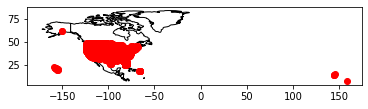

In [7]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [8]:
df_counties = bigquery_client.query('''
SELECT
  NAME,
  STATE_NAME,
  POP2000,
  shape_WKT
FROM `flights-328723.hospitals.locations_all`
''').result().to_dataframe(create_bqstorage_client=False)
df_counties.head()

,NAME,STATE_NAME,POP2000,shape_WKT
0,Johnson,Iowa,111006,MULTIPOLYGON (((-91.37131301578644 41.42487775...
1,Johnson,Iowa,111006,MULTIPOLYGON (((-91.37131301578644 41.42487775...
2,Fremont,Iowa,8010,MULTIPOLYGON (((-95.3948932409456 40.908703148...
3,Fremont,Iowa,8010,MULTIPOLYGON (((-95.3948932409456 40.908703148...
4,Muscatine,Iowa,41722,MULTIPOLYGON (((-91.07342897262018 41.33492537...


In [9]:
df_counties.shape

(6282, 4)

In [10]:
def search_point(lat, lon):
    
    sql = bigquery_client.query(f'''
    SELECT
    NAME,
    STATE_NAME,
    POP2000,
    shape_WKT
    FROM `flights-328723.hospitals.locations_all`
    WHERE ST_CONTAINS(SAFE.ST_GEOGFROMTEXT(shape_WKT), ST_GEOGPOINT({lat}, {lon}))
    ''').result().to_dataframe(create_bqstorage_client=False)
    return sql

In [11]:
result = search_point(-74.237, 42.037)
result

,NAME,STATE_NAME,POP2000,shape_WKT
0,Ulster,New York,177749,MULTIPOLYGON (((-74.37041002098069 41.59433191...
1,Ulster,New York,177749,MULTIPOLYGON (((-74.37041002098069 41.59433191...


In [12]:
def search_hospitals(lat, lon, distance=50):
  
    sql = bigquery_client.query(f'''
    SELECT
    *,
    ROUND(ST_DISTANCE(ST_GEOGPOINT(lon, lat), ST_GEOGPOINT({lat}, {lon})) / 1000, 2) as distance
    FROM
    `flights-328723.hospitals.hospitals_all`
    WHERE
    (ST_DISTANCE(ST_GEOGPOINT(lon, lat), ST_GEOGPOINT({lat}, {lon})) / 1000) < {distance}
    ORDER BY 3
    ''').result().to_dataframe(create_bqstorage_client=False)
    return sql

In [13]:
point = (-77.574722, 43.146732)
df = search_hospitals(*point)
df

,id,name,city,state,lon,lat,distance
0,862,Park Avenue Hospital,BRIGHTON,NY,-77.574722,43.146732,0.00
1,5540,County Home and Infirmary,BRIGHTON,NY,-77.618614,43.113392,5.14
2,5561,Genesee Hospital,BRIGHTON,NY,-77.595009,43.150063,1.69
3,5573,Highland Hospital,BRIGHTON,NY,-77.605003,43.135620,2.75
4,5676,Saint Marys Hospital,BRIGHTON,NY,-77.636665,43.149231,5.03
5,5694,Strong Memorial Hospital,BRIGHTON,NY,-77.626396,43.122562,4.98
6,5587,Lakeside Memorial Hospital,BROCKPORT,NY,-77.944733,43.220890,31.11
7,5646,Rochester General Hospital,IRONDEQUOIT,NY,-77.586945,43.192001,5.13
8,846,Convalescent Hospital for Children,SCOTTSVILLE,NY,-77.702782,43.080063,12.77


In [14]:
def popup_html(i):
    institution_name = df['name'].iloc[i] 
    city = df['city'].iloc[i]
    state = df['state'].iloc[i] 
    distance = df['distance'].iloc[i] 

    left_col_color = "#404040"
    right_col_color = "#E6E6E6"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="text-align: center; margin-bottom:10"; width="200px">{}</h4>""".format(institution_name) + """
</head>
    <table style="height: 126px; width: 350px">
<tbody>
<p class="aligncenter">
    <img src="https://www.pngmart.com/files/21/Hospital-Vector-PNG-Free-Download.png" alt="Hospital" style="width:120px;height:120px;">
</p>
<style>
.aligncenter {
    text-align: center;
}
</style>
<tr>
<td style="padding: 6px;background-color: """+ left_col_color +""";"><span style="color: #BFBFBF;">Institution Name</span></td>
<td style="padding: 6px;width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(institution_name) + """
</tr>
<tr>
<td style="padding: 6px;background-color: """+ left_col_color +""";"><span style="color: #BFBFBF;">City</span></td>
<td style="padding: 6px;width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(city) + """
</tr>
<tr>
<td style="padding: 6px;background-color: """+ left_col_color +""";"><span style="color: #BFBFBF;">State</span></td>
<td style="padding: 6px;width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(state) + """
</tr>
<tr>
<td style="padding: 6px;background-color: """+ left_col_color +""";"><span style="color: #BFBFBF;">Distance</span></td>
<td style="padding: 6px;width: 200px;background-color: """+ right_col_color +""";">{}</td>""".format(distance) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [15]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat))

In [16]:
x_loc = gdf.iloc[0]["geometry"].y
y_loc = gdf.iloc[0]["geometry"].x

m = folium.Map(location=[x_loc, y_loc], 
               zoom_start=8,
               min_zoom=5, 
               max_zoom=16,
               tiles='CartoDB positron')

for i in range(len(gdf)):
    lat = gdf.iloc[i]["geometry"].y
    lon = gdf.iloc[i]["geometry"].x
    
    html = popup_html(i)
    iframe = branca.element.IFrame(html=html,width=510,height=280)
    popup = folium.Popup(folium.Html(html, script=True), max_width=500)
    
    folium.Marker([lat, lon], 
                popup=popup,
                icon=folium.Icon(icon_color='white', 
                                icon='info', 
                                angle=0, 
                                prefix='fa'),
                ).add_to(m)

m

In [17]:
state_name = "New York"

In [18]:
def search_s_stats(state_name):
    
    sql = bigquery_client.query(f'''
    SELECT
      FARM_FINGERPRINT(c.shape_WKT) as id,
      c.NAME,
      COUNT(h.name) AS hospital_count,
      c.POP2000 AS Population,
      ROUND(c.POP2000/COUNT(h.name),0) AS people_per_hospital
    FROM
      `hospitals.locations_all` AS c,
      `hospitals.hospitals_all` AS h
    WHERE
      c.STATE_NAME='{state_name}'
      AND ST_CONTAINS(SAFE.ST_GEOGFROMTEXT(c.shape_WKT), 
      ST_GEOGPOINT(h.lon, h.lat))
    GROUP BY
      id,
      c.NAME,
      c.POP2000
    ORDER BY
      Population DESC
     ''').result().to_dataframe(create_bqstorage_client=False)
    return sql

In [19]:
df_stats = search_s_stats(state_name)


In [20]:
def search_state(state_name):
  
    sql = bigquery_client.query(f'''
    SELECT
        FARM_FINGERPRINT(shape_WKT) as id,
        NAME,
        STATE_NAME,
        POP2000,
        shape_WKT
    FROM
      `hospitals.locations_all`
    WHERE
      STATE_NAME='{state_name}'
    ''').result().to_dataframe(create_bqstorage_client=False)
    return sql

In [21]:
df = search_state(state_name)

In [22]:
len(df)

124

In [23]:
df_all = pd.merge(df, df_stats, 
                  left_on="id", 
                  right_on="id", 
                  how="left", 
                  sort=False
)

In [24]:
df_all.fillna(0, inplace=True)
df_all['geometry'] = geopandas.GeoSeries.from_wkt(df_all['shape_WKT'])
df_all.drop(["shape_WKT", "NAME_y", "Population"], axis=1, inplace=True)
geo_df = geopandas.GeoDataFrame(df_all)

In [25]:
df_all

,id,NAME_x,STATE_NAME,POP2000,hospital_count,people_per_hospital,geometry
0,-252273539208738728,Delaware,New York,48055,0.0,0.0,"MULTIPOLYGON (((-75.14828 41.85579, -74.78901 ..."
1,-252273539208738728,Delaware,New York,48055,0.0,0.0,"MULTIPOLYGON (((-75.14828 41.85579, -74.78901 ..."
2,4129834842666095084,Genesee,New York,60370,2.0,30185.0,"MULTIPOLYGON (((-78.46165 42.87340, -78.07070 ..."
3,4129834842666095084,Genesee,New York,60370,2.0,30185.0,"MULTIPOLYGON (((-78.46165 42.87340, -78.07070 ..."
4,-447440018826634405,Chenango,New York,51401,2.0,25701.0,"MULTIPOLYGON (((-75.42138 42.19417, -75.41035 ..."
...,...,...,...,...,...,...,...
119,7076580640889505586,Monroe,New York,735343,18.0,40852.0,"MULTIPOLYGON (((-77.99083 43.13124, -77.90852 ..."
120,-4847885239309532864,Fulton,New York,55073,2.0,27537.0,"MULTIPOLYGON (((-74.14292 43.25058, -74.22277 ..."
121,-4847885239309532864,Fulton,New York,55073,2.0,27537.0,"MULTIPOLYGON (((-74.14292 43.25058, -74.22277 ..."
122,-6708643694427271059,Warren,New York,63303,2.0,31652.0,"MULTIPOLYGON (((-73.60262 43.30334, -73.64421 ..."


In [26]:
def norm_col(column):
    norm = (column - column.min()) / (column.max() - column.min())
    return norm

In [27]:
geo_df["norm"] = norm_col(df_all.hospital_count)

In [28]:
x_loc = geo_df.geometry.centroid[0].y
y_loc = geo_df.geometry.centroid[0].x

m = folium.Map(location=[x_loc, y_loc], 
               zoom_start=8,
               min_zoom=5, 
               max_zoom=16,
               tiles='CartoDB positron')

# style the polygons based on "values" property
def style_fn(feature):
    x_val = feature["properties"]["norm"] + 0.05
    ss = {
        "fillColor": 'orange',
        "fillOpacity": x_val,
    }
    return ss

folium.GeoJson(
    geo_df.__geo_interface__,
    style_function=style_fn,
    tooltip=folium.features.GeoJsonTooltip(["NAME_x", "POP2000", "hospital_count"]),
).add_to(m)

m